In [1]:
import os
import sys

ROOT = os.getcwd()
WORK = os.path.join(ROOT, "work")
# MODEL = "ssd_mobilenet_v1_coco_2018_01_28"
MODEL = "ssd_mobilenet_v2_coco_2018_03_29"
os.makedirs(WORK, exist_ok=True)

# force tf2onnx to cpu
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['MODEL'] = MODEL
os.environ['WORK'] = WORK

In [ ]:
!cd $WORK; wget -q http://download.tensorflow.org/models/object_detection/$MODEL.tar.gz
!cd $WORK; tar zxvf $MODEL.tar.gz

In [2]:
!saved_model_cli show --dir $WORK/$MODEL/saved_model/ --tag_set serve  --signature_def serving_default

2023-04-12 18:22:15.600582: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, -1, -1, 3)
      name: image_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['detection_boxes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100, 4)
      name: detection_boxes:0
  outputs['detection_classes'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_classes:0
  outputs['detection_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: detection_scores:0
  outputs['num_detections'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: num_detections:0
Method name is: tensorflow/serving/predict


In [ ]:
# !python3 -m tf2onnx.convert --graphdef $WORK/$MODEL/frozen_inference_graph.pb --output $WORK/$MODEL.frozen.onnx \
#    --opset 10 \
#    --inputs image_tensor:0 \
#    --outputs num_detections:0,detection_boxes:0,detection_scores:0,detection_classes:0       

In [2]:
!python3 -m tf2onnx.convert --opset 10 --saved-model $WORK/$MODEL/saved_model --output $WORK/$MODEL.onnx

2023-04-12 18:36:41.668514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

2023-04-12 18:36:52,368 - WARNING - From /usr/local/lib/python3.6/dist-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2023-04-12 18:36:52,369 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2023-04-12 18:36:52.374346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-12 18:36:52.413190: I tensorflow/stream_executor/cuda/cuda_gpu_

In [ ]:
!cd $WORK
!wget -q http://images.cocodataset.org/val2017/000000088462.jpg

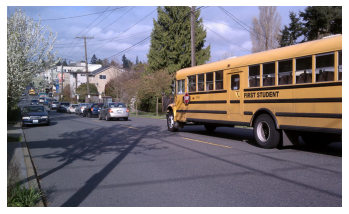

In [3]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
import matplotlib.pyplot as plt

img = Image.open("000000088462.jpg")
plt.axis('off')
plt.imshow(img)
plt.show()

In [4]:
img_data = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
img_data = np.expand_dims(img_data.astype(np.uint8), axis=0)
print(img_data.shape)

(1, 383, 640, 3)


In [9]:
import onnxruntime as rt
sess = rt.InferenceSession(os.path.join(WORK, MODEL + ".onnx"))

# we want the outputs in this order
# outputs_name = ["num_detections:0", "detection_boxes:0", "detection_scores:0", "detection_classes:0"]
outputs_name = [on.name for on in sess.get_outputs()]
inputs_name = sess.get_inputs()[0].name
result = sess.run(outputs_name, {inputs_name: img_data})
num_detections, detection_boxes, detection_scores, detection_classes = result
# there are 8 detections
print(num_detections)

print(detection_classes)

[10.]
[[ 6.  3.  3.  3.  3.  3.  3. 10. 10. 10.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


In [10]:
for output in sess.get_outputs():
    print(output.name)
print([on.name for on in sess.get_outputs()])
for input in sess.get_inputs():
    print(input.name)

num_detections
detection_boxes
detection_scores
detection_classes
['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
inputs


In [11]:
coco_classes = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
}

def draw_detection(draw, d, c):
    """Draw box and label for 1 detection."""
    width, height = draw.im.size
    # the box is relative to the image size so we multiply with height and width to get pixels.
    top = d[0] * height
    left = d[1] * width
    bottom = d[2] * height
    right = d[3] * width
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
    right = min(width, np.floor(right + 0.5).astype('int32'))
    label = coco_classes[c]
    label_size = draw.textsize(label)
    if top - label_size[1] >= 0:
        text_origin = tuple(np.array([left, top - label_size[1]]))
    else:
        text_origin = tuple(np.array([left, top + 1]))
    color = ImageColor.getrgb("red")
    thickness = 0
    draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness], outline=color)
    draw.text(text_origin, label, fill=color)  # , font=font)

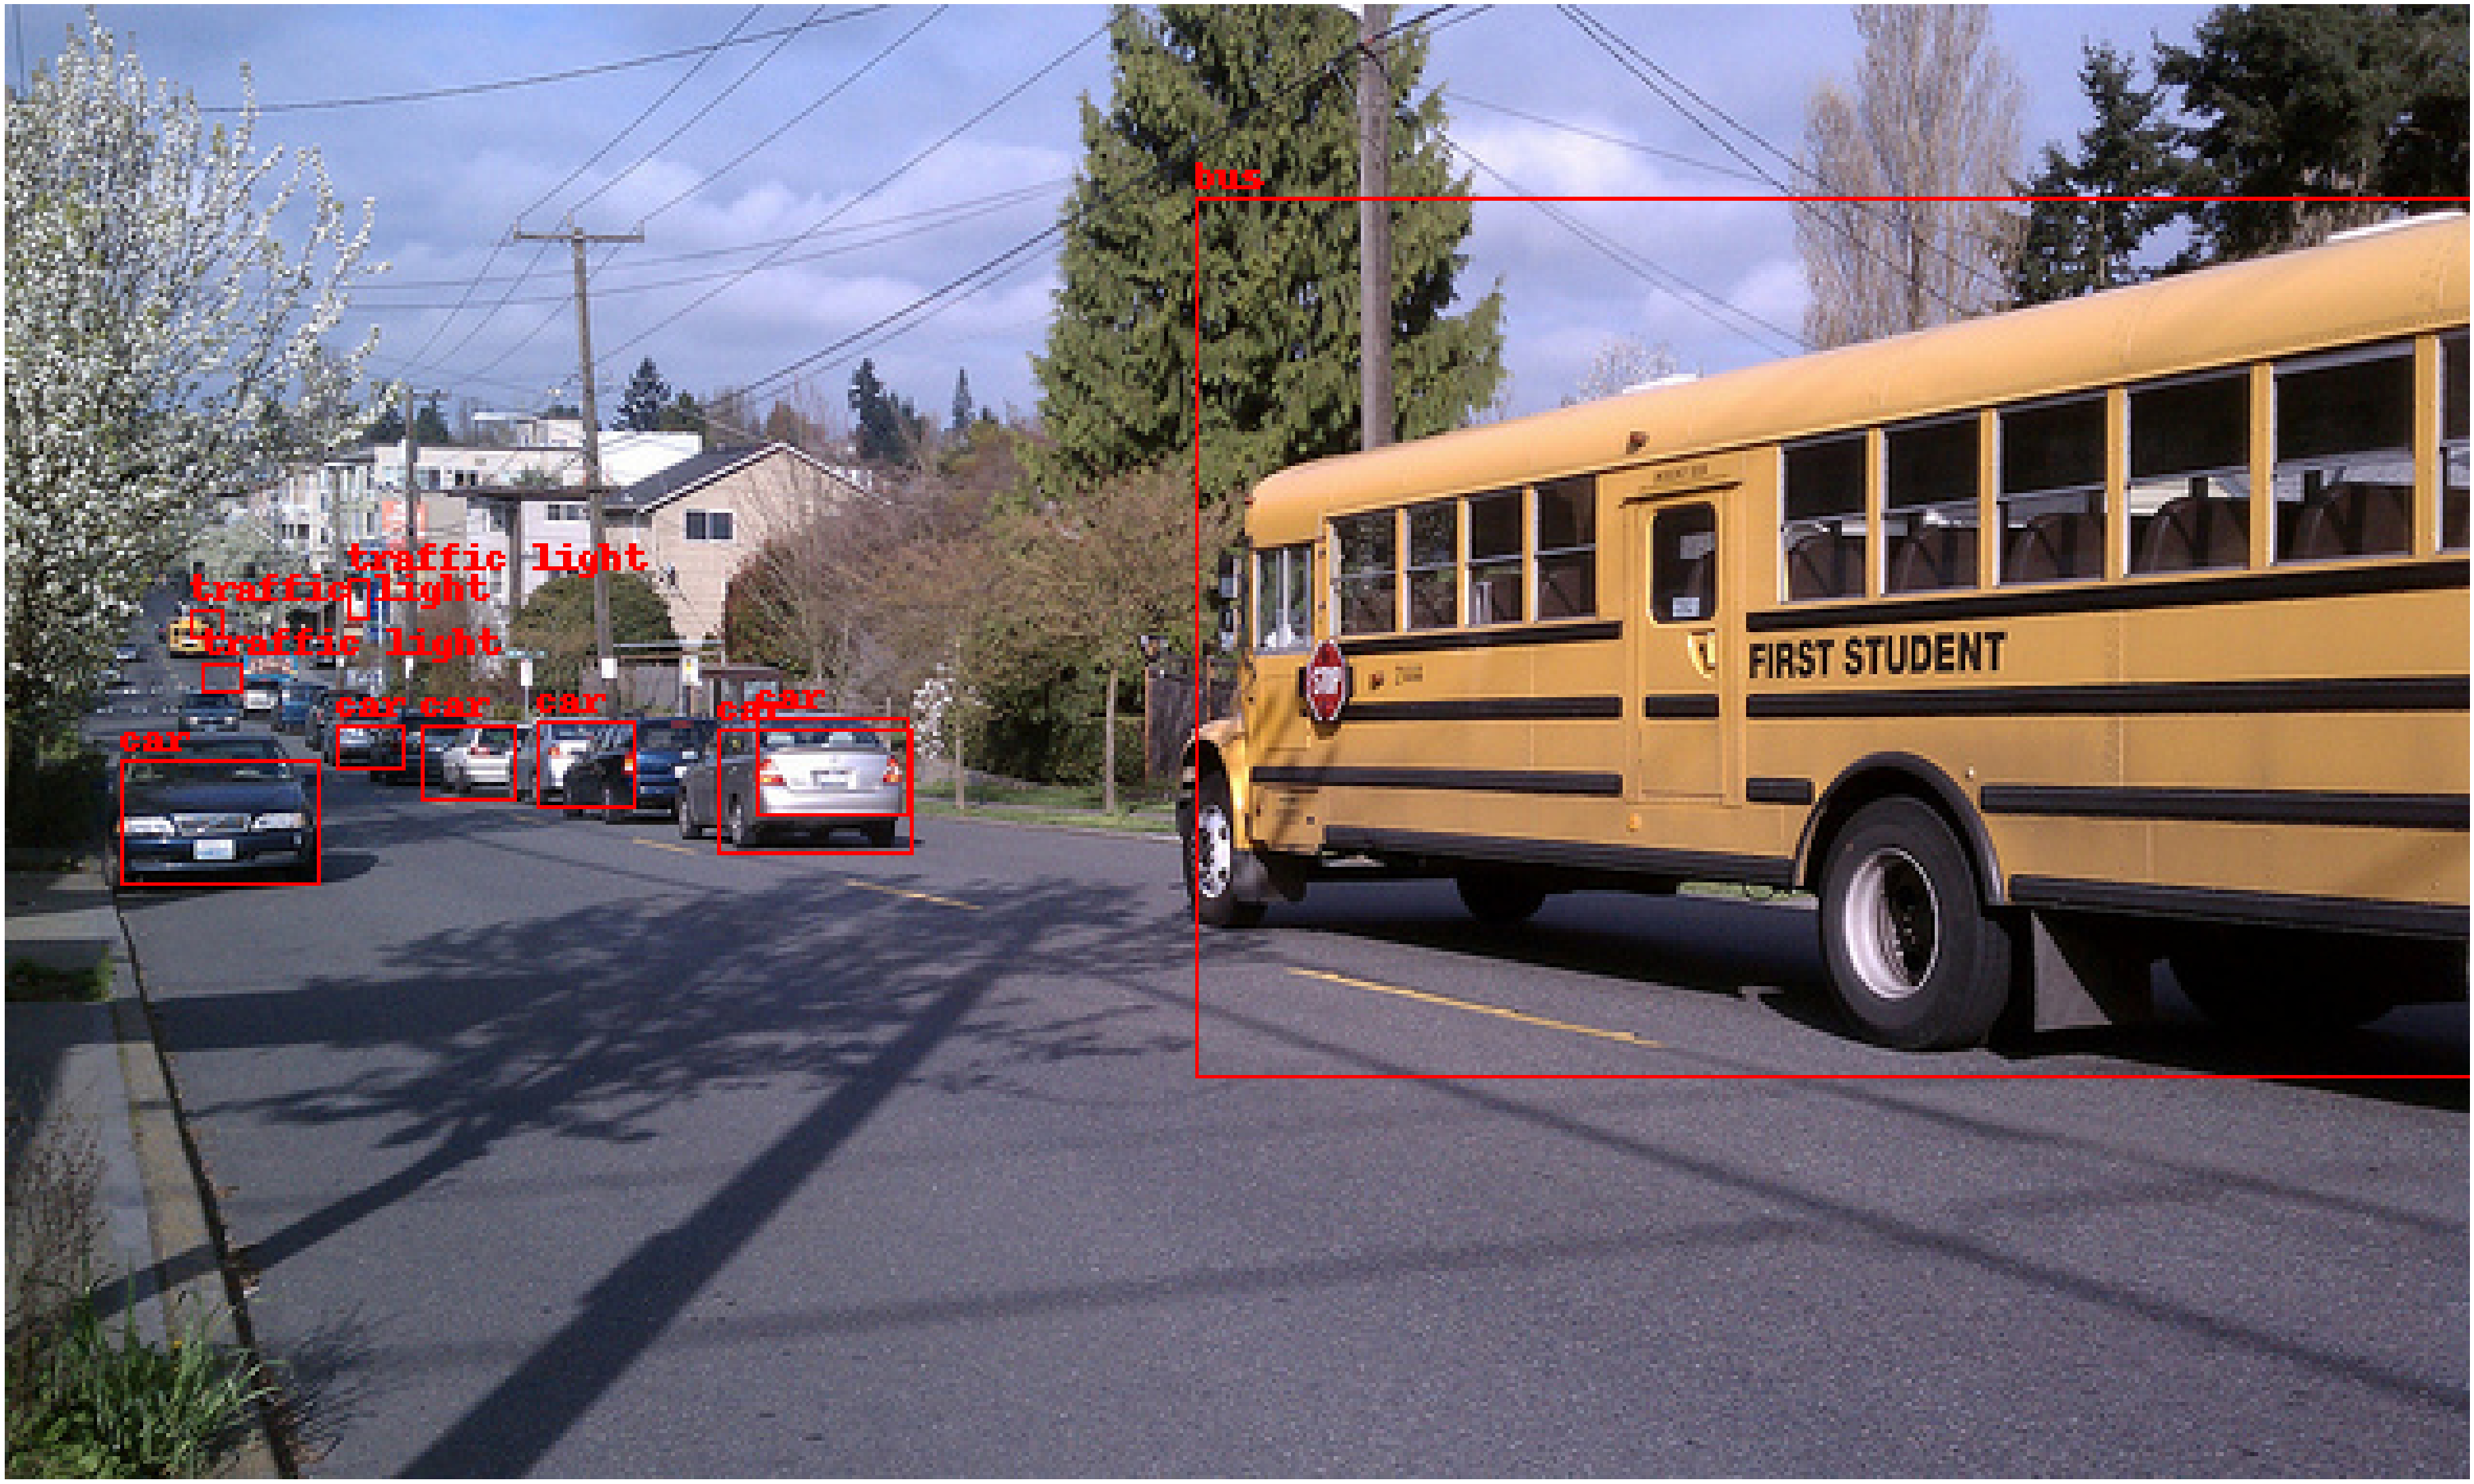

In [12]:
batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(img)
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
        draw_detection(draw, d, c)

plt.figure(figsize=(80, 40))
plt.axis('off')
plt.imshow(img)
plt.show()